loaded 1 existing images from dataset
loaded 1 existing weights from weights-minTrue-r20


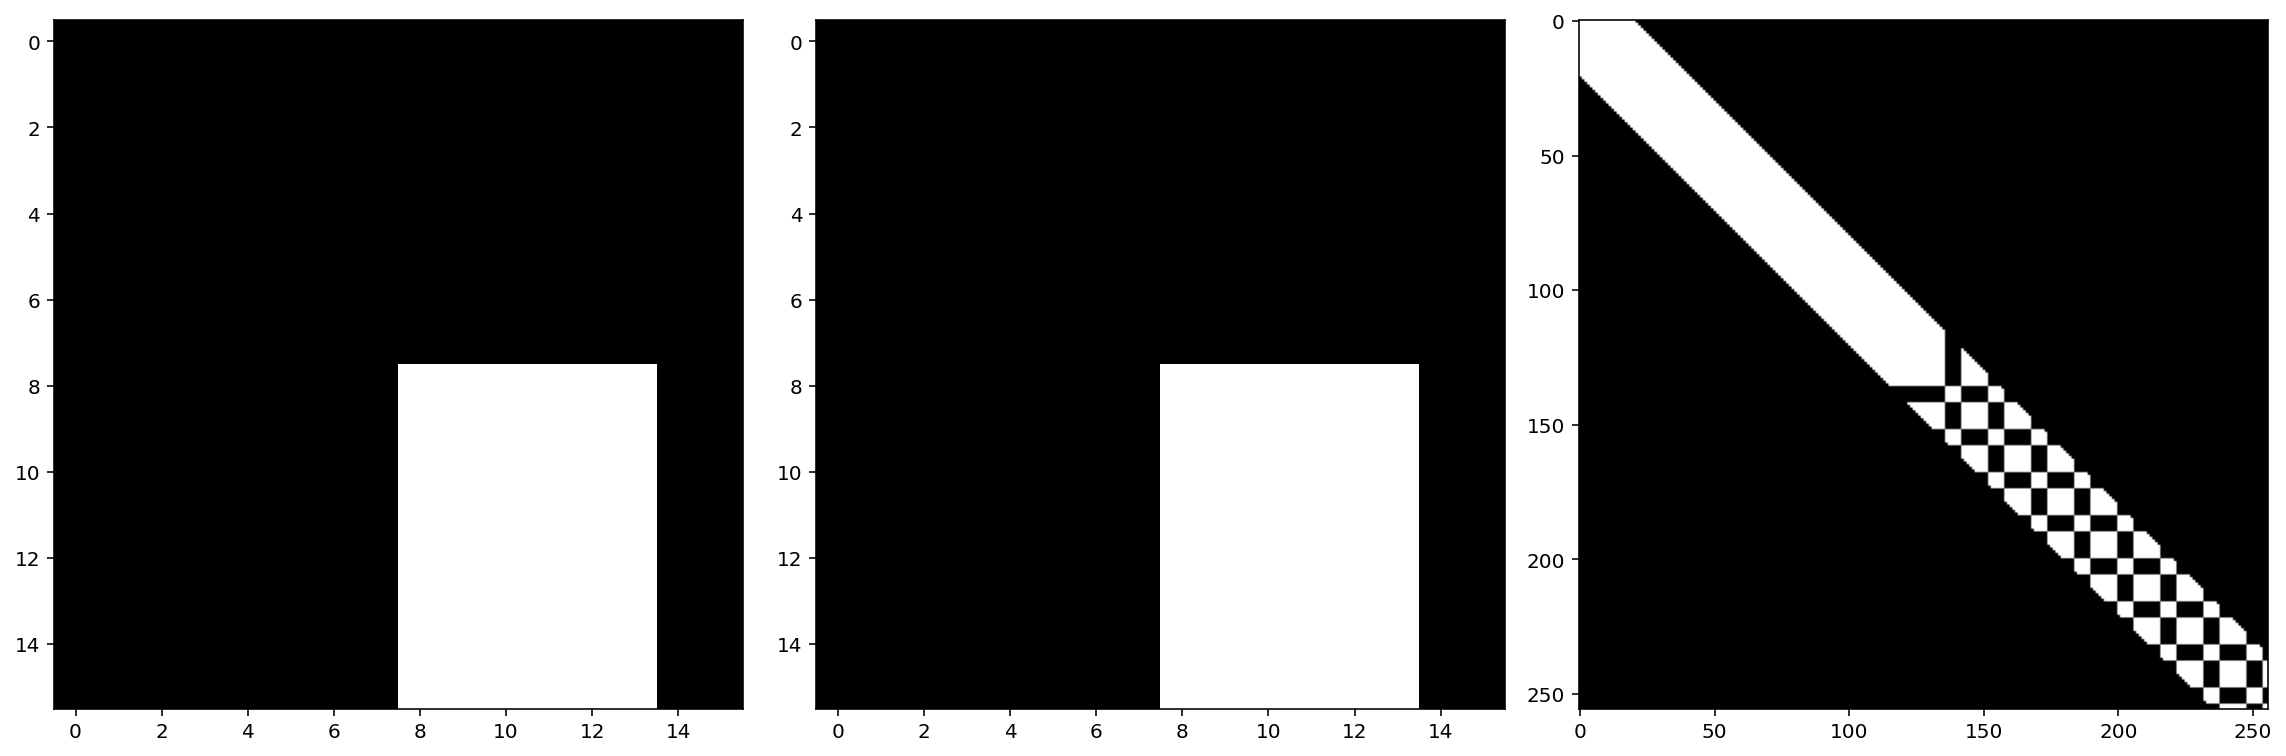

In [13]:
# THE DATA PORTION
# load a sample, see how it looks

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from net_argparser import net_argparser
from data import *

args = net_argparser(ipynb=True)
args.network = 1
args.total_images = 1
args.minify = True
args.radius = 20
args.img_size = [16,16] # the default is 32,32 anyway

train_dataset = SimpleDatasets(args, transform=transforms.ToTensor())
row = [train_dataset.get_image(0), train_dataset.get_segmentation(0), de_minW(train_dataset.get_weights(0))]

plot_multiple_images(0, row, figsize=args.img_size, ipynb=True)

torch.Size([256, 256])


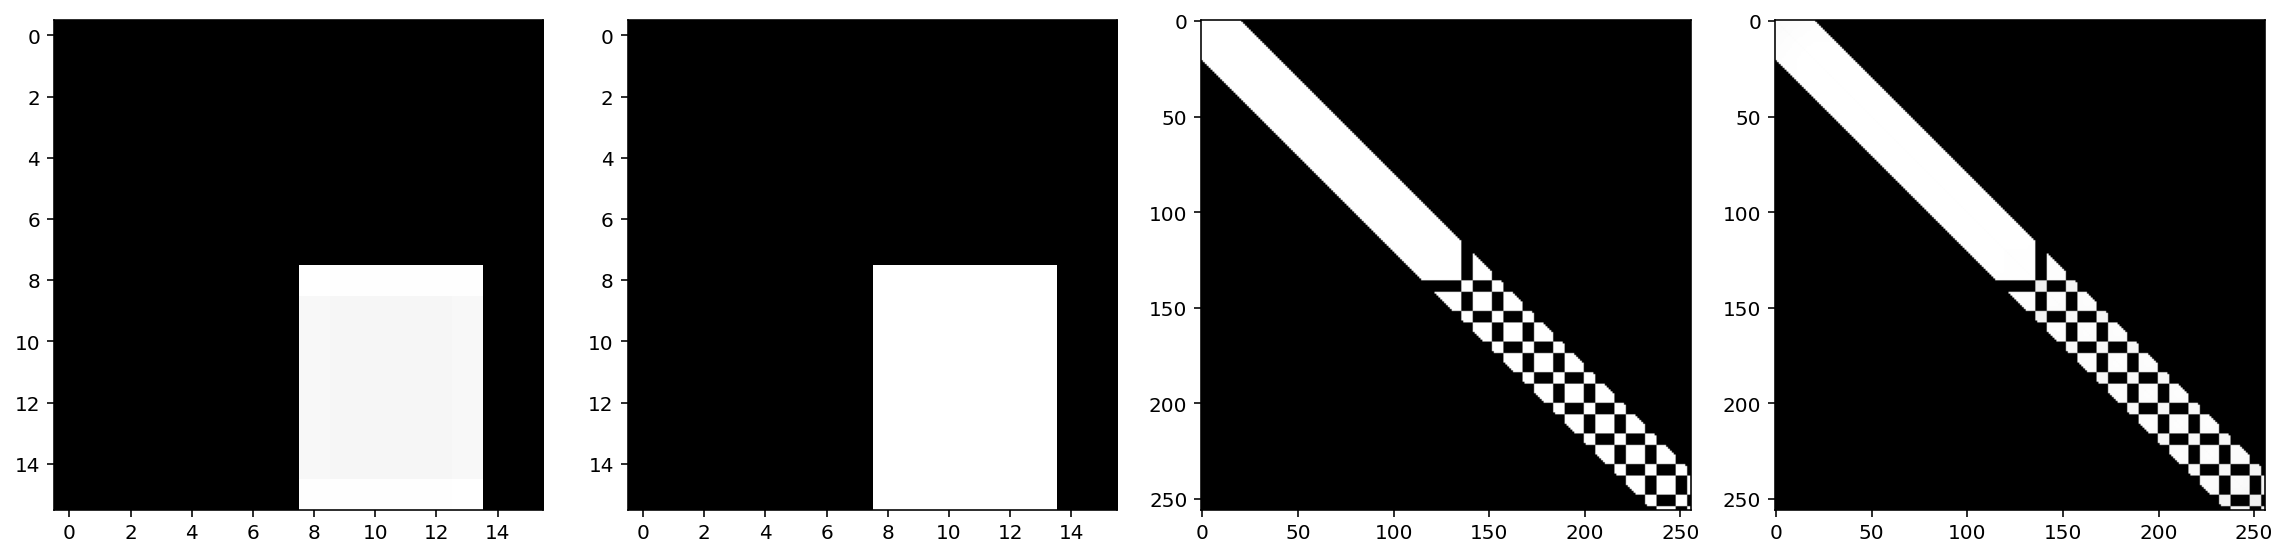

In [15]:
# try it without using the existing NC node
# TODO: fix

import torch

def distance_matrix(mat):
    d= ((mat.unsqueeze (0)-mat.unsqueeze (1))**2).sum(2)**0.5
    return d

# from https://github.com/dimkastan/PyTorch-Spectral-clustering/blob/master/FiedlerVectorLaplacian.py
# x is the adjacency matrix
x = row[2]
x = x.squeeze()
print(x.shape)

input = row[0]
test_d = distance_matrix(input)

D = x.sum(0).diag() # degree matrix
L = D - x.float() # laplacian
Lsym=torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D),-0.5)),L),torch.diag(torch.pow(torch.diag(D),-0.5))) # symmetric laplacian

[u,s,v]=torch.svd(Lsym)

y = u[:,-2]
y = y.view(1,1, args.img_size[0], args.img_size[1]) 

x = x[None,None,:,:]
Lsym = Lsym[None,None,:,:]


plot_images = [y, row[1], x, Lsym]
plot_multiple_images(0, plot_images, figsize=args.img_size, ipynb=True)

output:torch.Size([1, 1, 16, 16]), expected:torch.Size([1, 16, 16]), weights:torch.Size([1, 1, 256, 256])


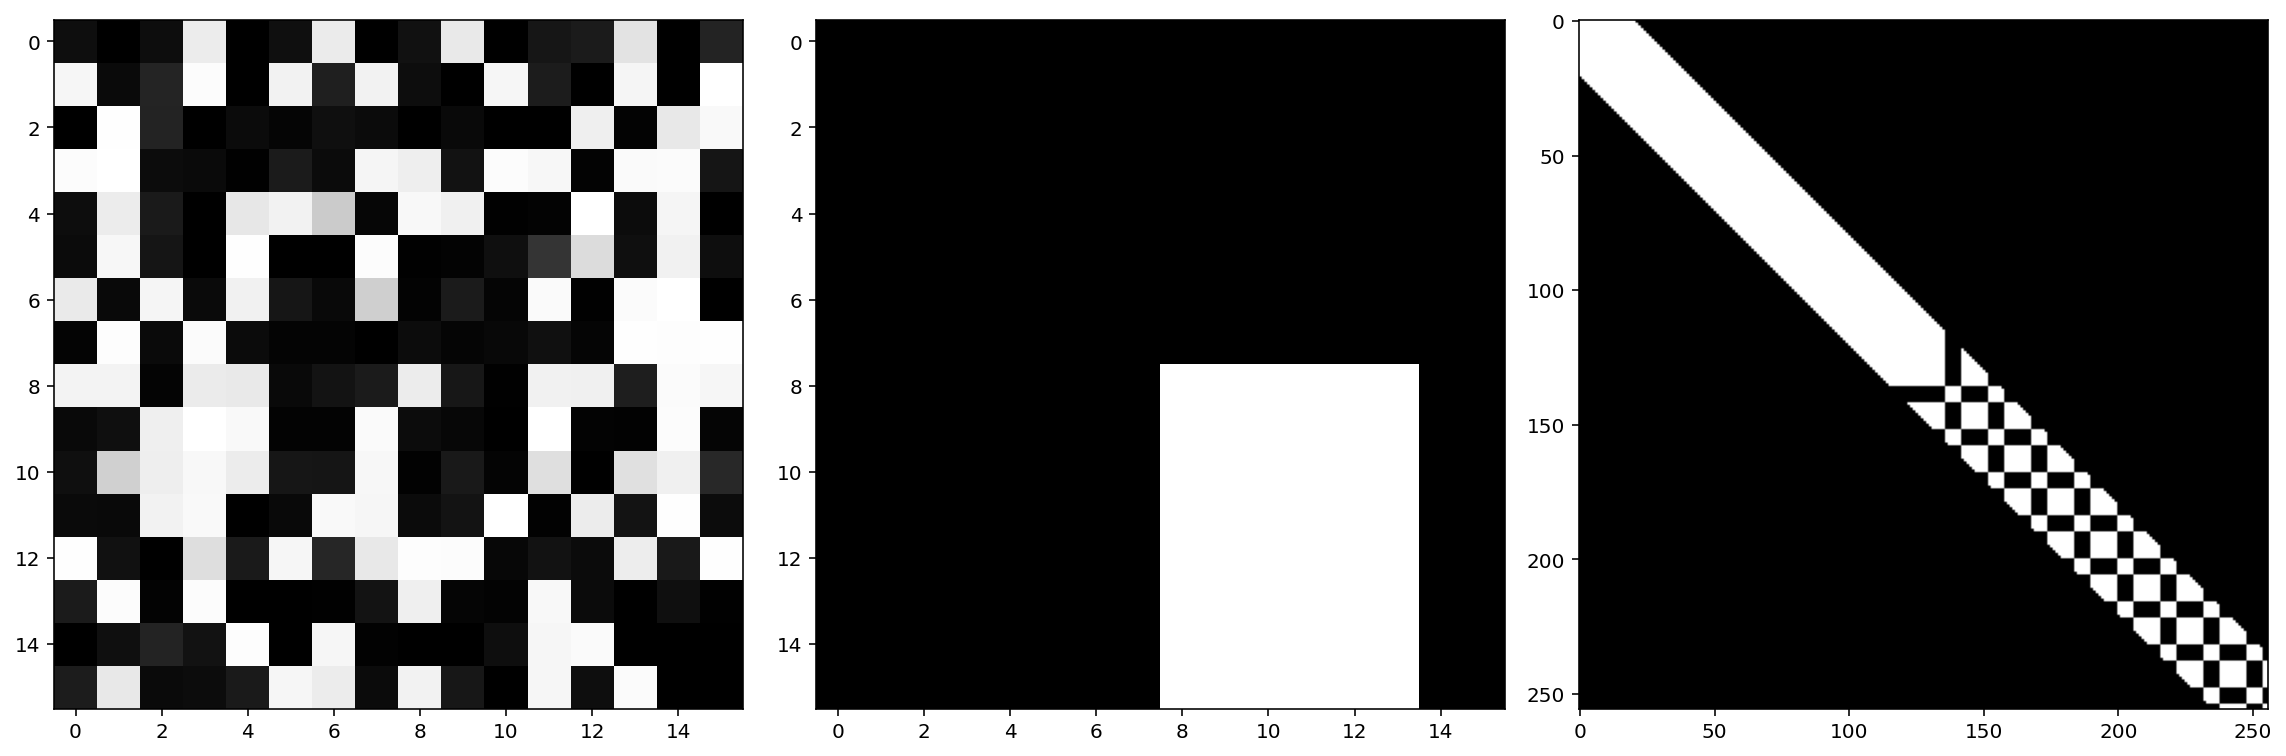

In [11]:
# The nc.py portion
# using the loaded data, see how it is segmented
# TODO: fix!

from nc import NormalizedCuts
from node import DeclarativeLayer

nc = NormalizedCuts(eps=1) # check if eps value is correct, also test gamma for gradients..
decl = DeclarativeLayer(nc)

x = row[2] # gets the full rank matrix
y = decl(x) # as in model.py
y = y.view(y.size(0), 1, args.img_size[0], args.img_size[1]) # convert from NC node into this

plot_images = [y, row[1], x] # x,y, expected y (the 2nd index must always be the weights (expects one less dim))
print(f'output:{y.shape}, expected:{row[1].shape}, weights:{x.shape}')


plot_multiple_images(0, plot_images, figsize=args.img_size, ipynb=True)